## <font color="Greenyellow">Trabajo de Fin Master 2: Modelos ensemble</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Ensemble Learning](#item3)

***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [1]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb
# Modelos
import joblib
from sklearn.metrics import f1_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report


#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


Recuperamos los mejores parametros:

In [5]:
best_params_rf = joblib.load('data/parametros/r_forest_best_params.pkl')
best_params_xgb = joblib.load('data/parametros/xgb_best_params.pkl')
best_params_rl = joblib.load('data/parametros/r_logistica_best_params.pkl')
best_params_lgb = joblib.load('data/parametros/lgbm_best_params.pkl')

Asignamos peso a cada modelo en función de su recall clase 1:

In [81]:
# usamos joblib para recupear recall_lightgbm.pkl
recall_rand_forest = joblib.load('data/metricas/recall_rand_forest.pkl')
recall_xgb = joblib.load('data/metricas/recall_xgb.pkl')
recall_rlog = joblib.load('data/metricas/recall_rlog.pkl')
recall_lightgbm = joblib.load('data/metricas/recall_lightgbm.pkl')
pesos_recall = [1*recall_rand_forest,
                5*recall_xgb,
                2*recall_rlog,
                1*recall_lightgbm]
# Hacemos que la suma de pesos_recall sea igual a 1
pesos_recall = pesos_recall / np.sum(pesos_recall)

In [82]:
pesos = pesos_recall
pesos

array([0.1107739 , 0.56904401, 0.20637329, 0.1138088 ])

***
<a id="item3"></a>
### <font color="Greenyellow">3. Ensemble Learning (Voting)</font>
[Volver al indice](#item0)

Aplicando pesos pero sin modificar el umbral

1. Inicio del entrenamiento...
... entrenamiento completado.
2. Generando metricas de evaluacion:
    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8982
    C. AUC: 0.9837
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8333
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.97      0.83      0.90        90

    accuracy                           1.00     56962
   macro avg       0.99      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



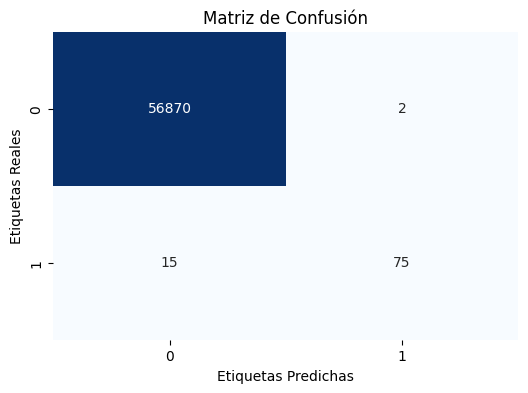


   Puntuaciones F1 de CV (k=5): [0.84563758 0.87248322 0.82758621 0.84768212 0.90789474]
   Promedio de F1 de CV: 0.8603
CPU times: total: 12.9 s
Wall time: 3min 2s


In [118]:
%%time
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)
# 2. Ensamblamos los modelos instanciando el VotingClassifier
ensemble_model = VotingClassifier(estimators=[('rf', model_1), ('xgb', model_2), ('rl', model_3), ('lgbm', model_4)],
                                  voting='soft',
                                  n_jobs=-1,
                                  weights=pesos
                                  )

# 3. Implementamos validacion cruzada (CV)
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

# 4. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
ensemble_model.fit(X_train, y_train)
print("... entrenamiento completado.")

# 5. Evaluación del Ensemble
print("2. Generando metricas de evaluacion:")
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(ensemble_model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

Aplicando pesos y modificando el umbral

In [119]:
umbral = 0.15

In [120]:
%%time
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)
# 2. Ensamblamos los modelos instanciando el VotingClassifier
ensemble_model = VotingClassifier(estimators=[('rf', model_1), ('xgb', model_2), ('rl', model_3), ('lgbm', model_4)],
                                  voting='soft',
                                  n_jobs=-1,
                                  weights=pesos
                                  )

# 3. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
ensemble_model.fit(X_train, y_train)
print("... entrenamiento completado.")

1. Inicio del entrenamiento...
... entrenamiento completado.
CPU times: total: 1.97 s
Wall time: 35.7 s


Evaluación con Validación Cruzada (k=5):
  Puntuaciones F1 de CV: [0.84563758 0.87248322 0.82758621 0.84768212 0.90789474]
  Promedio de F1 de CV: 0.8603 (+/- 0.0556)
  Promedio de Recall de CV: 0.7984 (+/- 0.0668)
Generando metricas de evaluacion:

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.85      0.86      0.85        90

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Precisión global del modelo: 0.9995
AUC del modelo: 0.9838


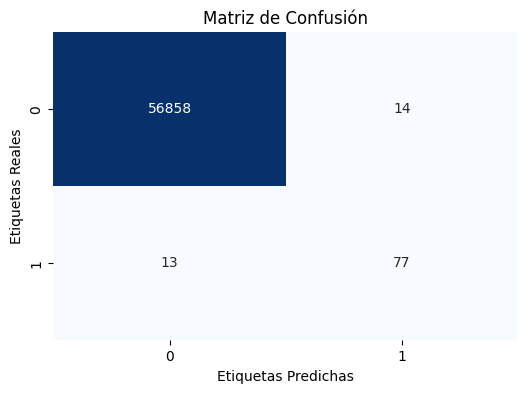

CPU times: total: 5.09 s
Wall time: 5min 48s


In [121]:
%%time
# 4. Evaluación del Ensemble
# Validación Cruzada (CV)
print(f"Evaluación con Validación Cruzada (k=5):")
cv_f1_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
cv_recall_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
print(f"  Puntuaciones F1 de CV: {cv_f1_scores}")
print(f"  Promedio de F1 de CV: {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores) * 2:.4f})")
print(f"  Promedio de Recall de CV: {np.mean(cv_recall_scores):.4f} (+/- {np.std(cv_recall_scores) * 2:.4f})")
# Evaluación del Ensemble: Calculamos las probabilidades de la clase 1
probs_1 = ensemble_model.predict_proba(X_test)[:, 1]
# Aplicamos el umbral para obtener las nuevas predicciones binarias
y_pred_umbral = np.where(probs_1 >= umbral, 1, 0)
print("Generando metricas de evaluacion:")
recall_minoritaria = recall_score(y_test, y_pred_umbral, pos_label=1)
f1 = f1_score(y_test, y_pred_umbral, pos_label=1)
auc = roc_auc_score(y_test, probs_1)
c_matrix = confusion_matrix(y_test, y_pred_umbral)
reporte_clasificacion = classification_report(y_test, y_pred_umbral)
print("\nClassification Report:\n", reporte_clasificacion)
plt.figure(figsize=(6,4))
precision_global = accuracy_score(y_test, y_pred_umbral)
print(f'Precisión global del modelo: {precision_global:.4f}')
print(f'AUC del modelo: {auc:.4f}')
# Heatmap de la matriz de confusión
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

***
[Volver al indice](#item0)

<a id="item3"></a>
### <font color="Greenyellow">4. Optimizacion de pesos</font>
[Volver al indice](#item0)

1. Iniciando gp_minimize con 50 llamadas para maximizar 'recall'...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 184.1007
Function value obtained: -0.7884
Current minimum: -0.7884
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 192.4347
Function value obtained: -0.7959
Current minimum: -0.7959
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 166.5613
Function value obtained: -0.7685
Current minimum: -0.7959
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 189.6838
Function value obtained: -0.7859
Current minimum: -0.7959
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 184.5061
Funct

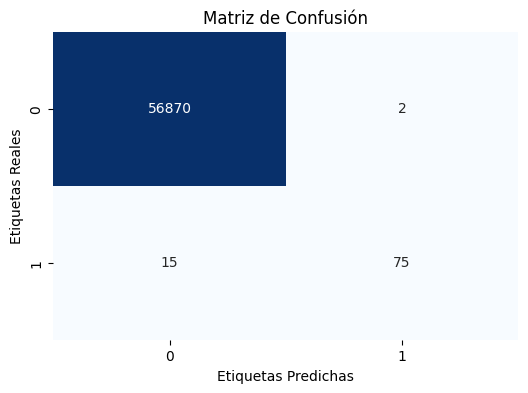


   Recall de la clase 1 (Test Set): 0.8333
   Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.97      0.83      0.90        90

    accuracy                           1.00     56962
   macro avg       0.99      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



In [80]:
from skopt import gp_minimize
from skopt.space import Integer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.ensemble import VotingClassifier
import numpy as np

# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)

estimators_list = [('rf', model_1), ('xgb', model_2), ('rl', model_3), ('lgbm', model_4)]

# 2. Definimos el espacio de búsqueda
space = [Integer(1, 5),
         Integer(1, 5),
         Integer(1, 5),
         Integer(1, 5)]

# 3. Definimos el parametro a optimizar (recall es negativo)
recall_scorer = make_scorer(recall_score)

# 4. Definimos funcion objetivo con lambda
objective = lambda pesos: -np.mean(
    cross_val_score(VotingClassifier(estimators=estimators_list, voting='soft',  weights=pesos, n_jobs=-1), 
                    X_train, y_train, cv=5, scoring=recall_scorer, n_jobs=-1)
)

# 5. Ejecutamos la optimizacion mediante busqueda bayesiana
n_calls = 50 

print(f"1. Iniciando optimizacion...")

res_gp = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=n_calls,
    random_state=semilla,
    n_jobs=-1,
    verbose=True
)

# 6. Mostramos los mejores resultados
best_pesos = res_gp.x
best_recall = -res_gp.fun # Convertir de vuelta a recall positivo

print("\n--- Resultados de la Optimización ---")
print(f"✨ Mejores pesos encontrados: {best_pesos}")
print(f"   Recall promedio de CV (clase 1) optimizado: {best_recall:.4f}")